# Implementation of a SQP for nonlinear optimal control
The goal of this exercise is to implement a SQP solver to solve a nonlinear optimal control problem.

Consider the pendulum below 

<img src='pendulum.png' width="150">

Assuming $m=l=1$, The dynamics of this pendulum is
$$\ddot{\theta} = u - g \sin\theta$$
which can be discretized with the following dynamics
$$\begin{align}\theta_{n+1} &= \theta_n + \Delta t \omega_n\\ 
\omega_{n+1} &= \omega_n + \Delta t (u_n - g \sin\theta_n)\end{align}$$
where $\theta_n$ is the angle of the pendulum with respect to the vertical at time step $n$ and $\omega_n$ its angular velocity. We will use $\Delta t = 0.01$.
The pendulum starts at configuration $\theta_0 = \omega_0 = 0$, i.e. all the way down with zero velocity and we would like to find
an optimal control that will bring it up to $\theta=\pi$ with zero velocities.

To get the pendulum to do this movement, we write the following optimal control problem
$$\begin{align}
& \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2\\
\textrm{subject to}\ \ & \theta_{n+1} = \theta_n + \Delta t \ \omega_n \\
& \omega_{n+1} = \omega_n + \Delta t\ (u_n - g \sin\theta_n)\\
& \theta_0 = \omega_0 = 0
\end{align}$$



## Question 1: write a SQP solver to solve this problem
To do so, please follow these steps:
* Write down the algorithm (in words not in code), i.e. write all the steps you need to take
* Write (in Latex) the gradient of the running cost at a given guess $\bar{x} = [\bar{\theta}_0, \bar{\omega}_0, \bar{u}_0, \bar{\theta}_1, \bar{\omega}_1, \bar{u}_1, \dots, \bar{\theta}_{300}, \bar{\omega}_{300}, \bar{u}_{300}]^T$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Write (in Latex) the Hessian of the running cost at a given guess $\bar{x}$, i.e. for given values $\bar{\theta}_n, \bar{\omega}_n, \bar{u}_n$ and implement a function that computes it
* Assume that the Hessian of the constraints is 0 (i.e. ignore the second order derivatives of the constraints)
* Write (in Latex) a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ (don't forget the constant terms in g) where $\Delta x$ represents a small variation around $\bar{x}$ and implement a function that computes both $G$ and $g$.
* Use these functions to construct the inner linear KKT system that you will solve using Numpy's solve function (this should resemble the KKT system you built in the first homework)
* Implement a function that computes the amount of constraint violation, i.e. the sum of the absolute values of all the constraints (i.e. assuming constraints of the form $c(x) = 0$ we want to compute $|c(x)|$).
* Implement a filter linear search to test if a step should be accepted. You will implement the (simplified) filter line search explained below.
* Terminate the algorithm when you either reached the maximum number of iterations (e.g. 100) or when the KKT optimality conditions $\nabla_x L$ and $\nabla_\lambda L$ are close to 0, e.g. $10^{-4}$.


Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver

### (Simple) filter linear search
Once you have a potential step $p_x$ and associated candidate Lagrange multipliers $p_\lambda$ (from the ``solve`` of the KKT system), you need to find a step $\alpha$ to update your guess of the solution $x_{guess}$ and the Lagrange multipliers $\lambda_{guess}$. We will accept a step that either reduces the amount of constraint violation or reduces the cost.

Let's denote $f(x)$ the cost at $x$ and $|c(x)|$ the amount of constraint violation at $x$. Initialize the variable $f_{best} = \infty$ and $c_{best}=\infty$ at the beginning of the SQP. 

Then do the following during the line search.
1. Set $\rho$ to a number between 0 and 1 (e.g. 0.5) and set $\alpha = 1$
2. If $f(x_{guess} + \alpha p_x) < f_{best}$ then set $f_{best} \leftarrow f(x_{guess} + \alpha p_x)$ and accept the step

   Or 

   If $|c(x_{guess} + \alpha p_x)| < c_{best}$ then set $c_{best} \leftarrow |c(x_{guess} + \alpha p_x)|$ and accept the step
3. If the step was not accepted set $\alpha \leftarrow \rho \alpha$ and go back to Step 2.
4. If the step was accepted update the guess $x_{guess} \leftarrow x_{guess} + \alpha p_x$ and the Lagrange multipliers $\lambda_{guess} \leftarrow (1-\alpha)\lambda_{guess} + \alpha p_{lambda}$

## Solution 1 


In [24]:
# Import necessary libraries
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum 

# Set the max number of iterations
N1 = 300 

# Given value of Delta t
delta_t = pendulum.dt

# Gravity 
gravity = pendulum.g

# Tolerance for the algorithm
tol = 1e-4

# We don't want to print every decimal!
np.set_printoptions(suppress=True, precision=4) 


### Algorithm 

Given below are the steps to be followed to implement an SQP for the given model with only equality constraints 
#### 1. Reformulating the cost function
Given the cost function, $$\min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10(\theta_n - \pi)^2 + 0.1\omega_n^2 + 0.1u_n^2$$ It appears similar to one for tracking a desired trajectory. So we shall reformulate it by expanding the term that depends on $\theta_n$ and ignore the constant terms. This leads us to the cost function, 
$\begin{equation} \notag \min_{\theta_n, \omega_n, u_n} \sum_{n=0}^{300} 10\theta_n^2 - 20\theta_n\pi + 0.1\omega_n^2 + 0.1u_n^2 \end{equation}$ OR
$ \begin{equation} \notag \min_{x} \sum_{n=0}^{300} \left( \frac{1}{2} x_n^T Q x_n -  x_{des}^T Q x_n \right) \end{equation} $ Where, 
$\begin{align}
    \notag &x_n = \begin{bmatrix} \theta_n \\  \omega_n \\ u_n\end{bmatrix} && Q = \begin{bmatrix} 20 & 0 & 0 \\ 0 & 0.2 & 0 \\ 0 & 0 & 0.2 \end{bmatrix} &&& x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix}
\end{align}$ 
Please note that the weight $R$ that is used to penalise the control input $u$ has been included inside of the $Q$ matrix, which is why it has not been explicity written in the above equation.

Rewriting this in matrix form and using the appropriate given terms, we get, 
$$\notag  \min_{\bar{x}} \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} $$
$\begin{align}
    \notag &\text{Where, } \quad \bar{x} = \begin{bmatrix} \bar{x}_0 \\ \bar{x}_1 \\ \bar{x}_2 \\ \vdots \end{bmatrix} &&G = \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix} &&&g^T = \begin{bmatrix} -x_{des}^T Q & -x_{des}^T Q & -x_{des}^T Q & \cdots \end{bmatrix} &&&&\text{with each} \quad \bar{x}_n = \begin{bmatrix} \bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n \end{bmatrix} \forall n \in \left[0, 300\right] \quad \text{and} \quad x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix}
\end{align}$

Using this logic, the function below is written to find the cost of a given guess

In [25]:
def cost_func(bar_x: np.ndarray, N=300):
    # Define the weighting matrix Q
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])

    # Define the desired state vector x_des
    x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

    # Construct the block diagonal matrix G with N copies of Q along the diagonal
    # Shape of G: (3*N, 3*N)
    G = block_diag(*([Q] * N))

    # Compute the vector g by repeating (-x_des.T @ Q) N times
    # (-x_des.T @ Q) results in a (3, 1) vector
    # After flattening and tiling, g has shape (3*N, 1)
    g = np.tile((-x_des.T @ Q).flatten(), N).reshape(-1, 1)

    return ((0.5 * ((bar_x.T @ G) @ bar_x)) + (g.T @ bar_x))[0, 0]


#### 2. Reformulating the equality constraints
We have been given the constraints, 
$\begin{align}
\notag \theta_0 &= 0 \\
\notag \omega_0 &= 0 \\
\notag \theta_{n+1} &= \theta_n + \Delta t \ \omega_n \\
\notag \omega_{n+1} &= \omega_n + \Delta t\ (u_n - g \sin\theta_n)
\end{align}$

As we can see, one of the constraints is non-linear. So we must first find a linear approximation of the constraints at a given guess $\bar{x}$ in a form $G(\bar{x}) \Delta x = g(\bar{x})$ where $\Delta x$ represents a small variation around $\bar{x}$. To do that, we shall perform the Taylor Expansion of the non-linear constraints around $\bar{x}$, which will be given by, 
$\begin{align} 
    \notag \Delta \theta_{n+1} &= \Delta \theta_{n} + \Delta t \Delta \omega_n \\
    \notag \Delta \omega_{n+1} &= \Delta \omega_{n} + \Delta t (\Delta u_n - g  \Delta \theta_n \cos \theta_n)
\end{align}$

Combining these constraints in the matrix form, we get,
$\begin{equation}\notag
    \begin{bmatrix} 1 & \Delta t & 0 & -1 & 0 & 0 \\ - \Delta t g \cos \bar{\theta_n} & 1 & \Delta t & 0 & -1 & 0 \end{bmatrix} \begin{bmatrix} \Delta \theta_n \\ \Delta \omega_n \\ \Delta u_n \\ \Delta \theta_{n+1} \\ \Delta \omega_{n+1} \\ \Delta u_{n+1} \end{bmatrix} = \begin{bmatrix} 0 \\ 0\end{bmatrix}
\end{equation}$

Now, we shall include the original, non-linear constraints to obtain, 
$\begin{equation}\notag
    \begin{bmatrix} 1 & \Delta t & 0 & -1 & 0 & 0 \\ - \Delta t g \cos \bar{\theta_n} & 1 & \Delta t & 0 & -1 & 0 \end{bmatrix} \begin{bmatrix} \Delta \theta_n \\ \Delta \omega_n \\ \Delta u_n \\ \Delta \theta_{n+1} \\ \Delta \omega_{n+1} \\ \Delta u_{n+1} \end{bmatrix} = \begin{bmatrix}  \theta_n + \Delta t \ \omega_n - \theta_{n+1} \\   \omega_n + \Delta t\ (u_n - g \sin\theta_n) - \omega_{n+1} \end{bmatrix}
\end{equation}$

Now, we shall include the linear constraints as well and stack all of them together to obtain sparse matrices $G(\bar{x})$ and $g(\bar{x})$, 

$\begin{align} 
    \notag G (\bar{x}) \Delta x &= g(\bar{x}) \\ 
    \notag \\  
    \notag \Rightarrow \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\ 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \cdots \\ 1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & 0 & \cdots \\ - \Delta t g \cos \bar{\theta_0} & 1 & \Delta t & 0 & -1 & 0 & 0 & 0 & 0 & \cdots \\ 0 & 0 & 0 & 1 & \Delta t & 0 & -1 & 0 & 0 & \cdots \\ 0 & 0 & 0 & - \Delta t g \cos \bar{\theta_1} & 1 & \Delta t & 0 & -1 & 0 & \cdots \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots\end{bmatrix}  \begin{bmatrix} \Delta \theta_0 \\ \Delta \omega_0 \\ \Delta u_0 \\ \Delta \theta_1 \\ \Delta \omega_1 \\ \Delta u_1 \\ \Delta \theta_2 \\ \Delta \omega_2 \\ \Delta u_2 \\ \vdots  \end{bmatrix} &= \begin{bmatrix} 0 \\ 0 \\ \bar{\theta}_0 + \Delta t \ \bar{\omega}_0 - \bar{\theta}_1 \\   \bar{\omega}_0 + \Delta t\ (\bar{u}_0 - g \sin\bar{\theta}_0) - \bar{\omega}_1 \\ \bar{\theta}_1 + \Delta t \ \bar{\omega}_1 - \bar{\theta}_2 \\   \bar{\omega}_1 + \Delta t\ (\bar{u}_1 - g \sin\bar{\theta}_1) - \bar{\omega}_2 \\ \vdots \end{bmatrix}
\end{align}$

Based on this logic, the below function was written to compute the values of $G(\bar{x})$ and $g(\bar{x})$ with a given guess $\bar{x}$.

In [26]:
def compute_G_g(bar_x: np.ndarray, N=300):
    """
    Compute the Jacobian matrix G and the residual vector g for the linear approximation
    of the constraints in the Sequential Quadratic Programming (SQP) method.

    This function linearizes the nonlinear constraints of the pendulum optimal control problem
    around the current guess `bar_x`. The constraints include the initial conditions and
    the dynamic equations governing the pendulum's motion.

    Args:
        bar_x (np.ndarray): 
            Current guess of the state vector, structured as follows:
            [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N, omega_N]
            - theta_n: Angle of the pendulum at time step n
            - omega_n: Angular velocity at time step n
            - u_n: Control input at time step n
            The length of `bar_x` should be `3 * N`, where N is the number of time steps.

    Returns:
        G (np.ndarray): 
            Jacobian matrix of the constraints with respect to the variables.
            Shape: (2 * N + 2, 3 * N1)
            Each row corresponds to a constraint, and each column corresponds to a variable
            in `bar_x`. The matrix is structured to accommodate the initial conditions and
            the dynamic constraints for each time step.

        g (np.ndarray): 
            Residual vector of the constraints evaluated at `bar_x`.
            Shape: (2 * N1 + 2, 1)
            Each entry represents the negative of the constraint function evaluated at
            the current guess `bar_x`. This vector is used to form the linearized
            constraints in the SQP algorithm.
    """
    # Initialize the Jacobian matrix G as an identity matrix for the initial constraints
    # Shape: (2, 3 * N)
    G = np.eye(2, 3 * N)

    # Initialize the residual vector g with zeros for the initial constraints
    # Shape: (2, 1)
    g = np.zeros((2, 1), dtype=np.float64)

    # Set the first element of G corresponding to theta_0 = 0
    G[0, 0] = 1

    # Set the second element of G corresponding to omega_0 = 0
    G[1, 1] = 1

    # Loop over each time step to add dynamic constraints
    # The loop increments by 3 because variables are ordered as [theta, omega, u]
    for i in range(0, (N - 1) * 3, 3):
        # Extract the current state and control from bar_x
        bar_theta_i = bar_x[i]       # theta_n
        bar_omega_i = bar_x[i + 1]   # omega_n
        bar_u_i = bar_x[i + 2]       # u_n
        bar_theta_ip1 = bar_x[i + 3]  # theta_{n+1}
        bar_omega_ip1 = bar_x[i + 4]  # omega_{n+1}

        # Construct the Jacobian submatrix for the current dynamic constraints
        G_i = np.hstack((
            # Zeros for variables before the current time step
            np.zeros((2, (i // 3) * 3)),

            # Partial derivatives for the dynamic constraints at time step n
            np.array([
                [1, delta_t, 0, -1, 0, 0],  # Derivatives for theta constraint
                [
                    # Derivative w.r.t theta_n for omega constraint
                    -(delta_t * gravity * np.cos(bar_theta_i)[0]),
                    1,
                    delta_t,
                    0,
                    -1,
                    0
                ]  # Derivatives for omega constraint
            ], dtype=np.float64),

            # Zeros for variables after the current time step
            np.zeros((2, (N - 2 - (i // 3)) * 3))
        ))

        # Vertically stack the new constraints into the Jacobian matrix G
        G = np.vstack((G, G_i))

        # Compute the residuals for the current dynamic constraints
        g_i = np.vstack((
            [
                bar_theta_i + (delta_t * bar_omega_i) - bar_theta_ip1
            ],  # Residual for theta constraint: theta_n + delta_t * omega_n - theta_{n+1}
            [
                bar_omega_i + \
                (delta_t * (bar_u_i - (gravity * np.sin(bar_theta_i)))) - bar_omega_ip1
            ]  # Residual for omega constraint: omega_n + delta_t * (u_n - g*sin(theta_n)) - omega_{n+1}
        ))

        # Vertically stack the new residuals into the residual vector g
        g = np.vstack((g, g_i))

    return G, g

#### 3. Forming the Lagrangian
Now that we have the basic requirments for constrained optimisation with equality constraints, we shall form the Lagrangian as shown below 
$$ \mathcal{L}(x, \lambda) = f(x) + \lambda ^ T g(x) $$

Where, 
$$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} \quad \text{and} \quad g(\bar{x}) = G(\bar{x}) \Delta x$$
Please note that although the variables $G$ and $g$ are repeated, they have different meanings.

Using this, we can write the KKT Conditions to be, 
$\begin{align}
    \notag \nabla f(x) + \lambda \nabla g(x) &= 0 \\
    \notag g(x) &= 0
\end{align}$

And all terms have been defined in the previous steps. 

#### 4. Finding the gradient of the cost

Before we move on to solving the SQP, we need to do a couple of more steps, one of which is to find the gradient of the cost function, $$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x}$$ 

Let us recall that in lecture 2, a shortcut method was taught to find the gradient of a function. If a function is of the form, 
$\begin{align}
    \notag f(x) &= x^T P x + q^T x \\
    \notag \Rightarrow \nabla f(x) &= 2Px + q \\
    \notag \text{and} \quad \nabla ^2 f(x) &= 2 P
\end{align}$

By applying this trick to our equation, we can see that, 
$\begin{align}
\notag \nabla f(\bar{x}) &= 2 \cdot \frac{1}{2} G \bar{x} + g \\
\notag \Rightarrow \nabla f(\bar{x}) &= G \bar{x} + g \\
\end{align}$
$\begin{align}
    \notag &\text{Where, } \quad \bar{x} = \begin{bmatrix} \bar{x}_0 \\ \bar{x}_1 \\ \bar{x}_2 \\ \vdots \end{bmatrix} &&G = \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix} &&&g = \begin{bmatrix} (-x_{des}^T Q)^T \\ (-x_{des}^T Q)^T \\ (-x_{des}^T Q)^T \\ \vdots \end{bmatrix} &&&&\text{with each} \quad \bar{x}_n = \begin{bmatrix} \bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n \end{bmatrix} \forall n \in \left[0, 300\right] , \quad x_{des} = \begin{bmatrix} \pi \\ 0 \\ 0 \end{bmatrix} , \quad Q = \begin{bmatrix} 20 & 0 & 0 \\ 0 & 0.2 & 0 \\ 0 & 0 & 0.2 \end{bmatrix}
\end{align}$

The below function employs this logic to compute the gradient of the running cost.

In [27]:
def cost_grad(bar_x: np.ndarray, N=300):
    """
    Compute the gradient of the cost function for the optimal control problem.

    The cost function is defined as:
        f(x) = (1/2) * x^T * G * x + g^T * x
    where:
        - G is a block diagonal matrix with N copies of matrix Q along its diagonal.
        - g is a column vector where each 3-element block is (-x_des^T * Q)^T.

    This function calculates the gradient ∇f(x) = G * x + g.

    Args:
        bar_x (np.ndarray):
            Current guess of the state vector, structured as follows:
            [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N, omega_N]
            - theta_n: Angle of the pendulum at time step n
            - omega_n: Angular velocity at time step n
            - u_n: Control input at time step n
            The length of `bar_x` should be `3 * N`.

    Returns:
        np.ndarray:
            The gradient of the cost function evaluated at `bar_x`.
            Shape: (3 * N, 1)
            Each element corresponds to the partial derivative of the cost
            function with respect to the corresponding state variable in `bar_x`.
    """
    # Define the weighting matrix Q
    Q = np.array([
        [20, 0, 0],
        [0, 0.2, 0],
        [0, 0, 0.2]
    ])

    # Define the desired state vector x_des
    x_des = np.array([
        [np.pi],
        [0],
        [0]
    ])

    # Construct the block diagonal matrix G with N copies of Q along the diagonal
    # Shape of G: (3*N, 3*N)
    G = block_diag(*([Q] * N))

    # Compute the vector g by repeating (-x_des.T @ Q) N times
    # (-x_des.T @ Q) results in a (3, 1) vector
    # After flattening and tiling, g has shape (3*N, 1)
    g = np.tile((-x_des.T @ Q).flatten(), N).reshape(-1, 1)

    # Compute and return the gradient of the cost function: ∇f(x) = G * bar_x + g
    # bar_x is expected to be a (3*N, 1) vector
    return ((G @ bar_x) + g)

#### 5. Finding the hessian of the Lagrangian

This is the final step before solving the QP. We shall find the hessian of the Lagrangian formulated as, 
$$ \mathcal{L}(x, \lambda) = f(x) + \lambda ^ T g(x) $$

Where, 
$$f(x) = \frac{1}{2} \bar{x}^T G \bar{x} + g^T \bar{x} \quad \text{and} \quad g(\bar{x}) = G(\bar{x}) \Delta x$$

Please note that although the variables $G$ and $g$ are repeated, they have different meanings.

The hessian of the Lagrangian will be given by, 
$$ \nabla ^2 \mathcal{L} (x, \lambda) = \begin{bmatrix} \frac{\partial ^2 \mathcal{L}}{\partial x^2} & \frac{\partial ^2 \mathcal{L}}{\partial x \partial \lambda} \\ \frac{\partial ^2 \mathcal{L}}{\partial \lambda \partial x} & \frac{\partial ^2 \mathcal{L}}{\partial \lambda ^2}\end{bmatrix}$$

Here, we must ignore the second order derivatives of the constraints. This results in the Hessian of the Lagrangian becoming, 
$$ \nabla ^2 \mathcal{L} (x, \lambda) \approx  \nabla_{xx} ^2 \mathcal{L} (x)$$

Applying the same shortcut method to find the gradient and hessian, we can find that, 
$$ \nabla_{xx} ^2 \mathcal{L} (x) = 2 \cdot \frac{1}{2} \begin{bmatrix} Q & 0 & 0 & \cdots \\ 0 & Q & 0 & \cdots \\ 0 & 0 & Q & \cdots \\ \vdots & \vdots & \vdots & \ddots\end{bmatrix}  $$

We shall use this logic to write the function for this computation, as shown below.

In [28]:
def compute_hessian_L(N=300):
    """Function to compute the hessian of the lagrangian, ignoring second order derivatives of the constraints

    Returns:
        np.ndarray: Hessian of the lagrangian
    """
    return block_diag(*([np.array([[20, 0, 0], [0, 0.2, 0], [0, 0, 0.2]])] * N))

#### 6. Solving the KKT System
Now that we have obtained all the prerequsites for forming the KKT System of equations, we shall now have to solve the QP, 
$$
\begin{equation}
\begin{aligned}
    \notag & \min_{p} \frac{1}{2} p^T \nabla_{xx}^2 \mathcal{L}(x_k) p + p^T \nabla f(x_k) \\
    \notag  & \text{subject to } \nabla g(x_k)^T p + g(x_k) = 0
\end{aligned}
\end{equation}$$ 

Which is the same as solving

$$\begin{equation}\notag 
    \begin{bmatrix} 
        \nabla^2_{xx} \mathcal{L}(x_k) & \nabla g(x_k) ^T \\
        \nabla g(x_k) & 0 
    \end{bmatrix}
    \begin{pmatrix} 
        p_k \\ 
        \lambda_{k+1} 
    \end{pmatrix} 
    = 
    \begin{pmatrix} 
        -\nabla f(x_k) \\ 
        -g(x_k) 
    \end{pmatrix}
\end{equation}$$

Where $\nabla g(x_k) $ is the Jacobian we computed earlier, when we linearised the constraints.

The below function was written based on this logic.

In [29]:
def solve_KKT_eq_constr(bar_x: np.ndarray):
    """
    Solves the Karush-Kuhn-Tucker (KKT) system for the current guess of variables in the SQP algorithm.

    This function constructs and solves the KKT system to obtain the search direction for the variables
    and the updated Lagrange multipliers based on the current guess `bar_x`.

    Parameters:
    ----------
    bar_x : np.ndarray
        Current guess of the optimization variables, structured as
        [θ₀, ω₀, u₀, θ₁, ω₁, u₁, ..., θₙ, ωₙ, uₙ]^T,
        where θ is the angle, ω is the angular velocity, and u is the control input at each time step.

    Returns:
    -------
    pk : np.ndarray
        Search direction for the optimization variables. This vector indicates how to update `bar_x` to move towards the optimum.

    lambda_kp1 : np.ndarray
        Updated Lagrange multipliers corresponding to the constraints. These multipliers provide sensitivity information about the constraints.
    """
    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    lag_hess_mat = compute_hessian_L()

    # Compute the Jacobian matrix of the constraints and the constant term
    # G(x) represents the Jacobian of the constraints evaluated at the current guess `bar_x`
    # g(x) represents the residual of the constraints evaluated at the current guess `bar_x`
    const_jac_mat, const_mat = compute_G_g(bar_x=bar_x)

    # Compute the gradient of the cost function with respect to the optimization variables at `bar_x`
    cost_grad_mat = cost_grad(bar_x)

    # Assemble the left-hand side (LHS) of the KKT system
    # The LHS matrix is a block matrix composed of the Hessian of the Lagrangian and the constraint Jacobian
    LHS = np.block([
        [lag_hess_mat, const_jac_mat.T],
        [const_jac_mat, np.zeros(
            (const_jac_mat.shape[0], const_jac_mat.shape[0]))]
    ])

    # Assemble the right-hand side (RHS) of the KKT system
    # The RHS vector combines the negative gradient of the cost and the negative constraint residuals
    RHS = np.vstack((-cost_grad_mat, -const_mat))

    # Solve the KKT system to obtain the search direction `pk` and the updated Lagrange multipliers `lambda_kp1`
    res = np.linalg.solve(LHS, RHS)

    # Extract the search direction for the optimization variables from the solution
    # Assumes that the first 3*N elements correspond to `pk`
    pk = res[:3*N1, 0]

    # Extract the updated Lagrange multipliers from the solution
    # Assumes that the remaining elements correspond to `lambda_kp1`
    lambda_kp1 = res[3*N1:, 0]

    return pk, lambda_kp1

#### 7. Total constraint violation

Now, we need to write a function to find the total constraint violation. This would just be the sum of all the rows of $g(x)$.

In [30]:
def tot_constraint_violation_eq(bar_x: np.ndarray):
    """
    Computes the total constraint violation for the current guess of optimization variables.

    This function calculates the sum of the absolute values of all constraint residuals
    evaluated at the current guess `bar_x`. It provides a measure of how much the current
    solution violates the constraints, which is useful for assessing feasibility and
    convergence in the SQP algorithm.

    Parameters
    ----------
    bar_x : np.ndarray
        Current guess of the optimization variables, structured as
        [θ₀, ω₀, u₀, θ₁, ω₁, u₁, ..., θₙ, ωₙ, uₙ]^T,
        where θ is the angle, ω is the angular velocity, and u is the control input at each time step.

    Returns
    -------
    float
        The total constraint violation, calculated as the absolute sum of all constraint residuals.
    """
    # Compute the Jacobian matrix of the constraints and the constraint residuals at `bar_x`
    _, g = compute_G_g(bar_x)

    # Calculate the total constraint violation by summing the absolute values of the residuals
    total_violation = np.sum(abs(g))

    return total_violation

#### 8. Filter Line search

Now that we have a value of $\bar{x}$, the next thing to do is perform line search to compute $\alpha$. We shall use the total constraint violation function for this purpose. 

In [31]:
# Initialize the guess for the decision variables (theta, omega, control inputs)
# Assuming each time step has 3 variables: theta (angle), omega (angular velocity), and u (control input)
# Therefore, for N1 time steps, the total number of variables is 3*N1
x_guess = np.zeros((3 * N1, 1))  # Initial guess set to zero for all variables

# Initialize the guess for the Lagrange multipliers (dual variables)
# There are two equality constraints per time step: dynamics for theta and omega
# Additionally, there are 2*N1 inequality constraints for control input bounds (u_max and u_min)
# Initial guess set to zero for all dual variables
lambda_guess = np.zeros(((2 + (2 * N1)), 1))

# Initialize line search parameters
alpha = 1       # Initial step size
rho = 0.5       # Reduction factor for step size during backtracking line search

# Initialize best cost and constraint violation to infinity
# These will be updated to keep track of the best (lowest) cost and lowest constraint violation achieved
c_best = np.inf  # Best (minimum) constraint violation found so far
cost_best = np.inf  # Best (minimum) cost found so far

# Initialize history lists to store cost, step size (alpha), and constraint violations across iterations
cost_history = []      # List to store the cost at each iteration
alpha_history = []     # List to store the step size alpha at each iteration
c_history = []         # List to store the constraint violation at each iteration

# Start the Sequential Quadratic Programming (SQP) optimization loop
for i in range(0, N1):
    # Solve the Karush-Kuhn-Tucker (KKT) conditions to obtain the search direction (pk) and dual variables (pLambda)
    # This function should return the step direction and updated dual variables based on current guess
    pk, pLambda = solve_KKT_eq_constr(x_guess)

    # Reshape pk to ensure it has the correct dimensions (3*N1 x 1)
    # The number 900 implies that N1 = 300; however, it's better to use 3*N1 for flexibility
    pk = pk.reshape(900, 1)  # Reshaping the search direction vector

    # Perform backtracking line search to find an appropriate step size (alpha)
    # The line search aims to ensure that both the cost decreases and constraint violations are minimized
    while ((cost_func(x_guess + (alpha * pk)) > cost_best) &
           (tot_constraint_violation_eq(x_guess + (alpha * pk)) > c_best)):
        # Reduce the step size by multiplying with rho (0.5)
        alpha = rho * alpha

    # Update the best constraint violation and best cost based on the new candidate solution
    # Compute total constraint violation
    c_best = tot_constraint_violation_eq(x_guess + (alpha * pk))
    # Compute the cost of the new candidate solution
    cost_best = cost_func(x_guess + (alpha * pk))

    # Record the history of cost, alpha, and constraint violation for analysis
    alpha_history.append(alpha)          # Store the current step size
    # Store the current constraint violation
    c_history.append(c_best)
    cost_history.append(cost_best)       # Store the current cost

    # Print the current cost and constraint violation for monitoring progress
    print(
        f"Current Cost = {cost_best}  Current Constraint Violation = {c_best}")

    # Update the current guess of the decision variables by taking a step in the direction of pk scaled by alpha
    x_guess = x_guess + (alpha * pk)  # Update the solution vector

    # Check if the current constraint violation is below the specified tolerance (tol)
    if (c_best < tol):
        break  # If constraints are sufficiently satisfied, terminate the optimization loop

    # Update the guess for the dual variables (Lagrange multipliers) using a convex combination
    # This helps in stabilizing the dual variable updates
    lambda_guess = ((1 - alpha) * lambda_guess) + \
        (alpha * pLambda)  # Update dual variables

# After completing the iterations, print the total number of iterations performed
print(f"Total iterations needed = {i+1}")

# Extract the optimized variables for analysis and visualization
# Assuming the ordering of variables in x_guess is [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_N1-1, omega_N1-1, u_N1-1]
# Extract theta (angle) variables every 3 steps starting at index 0
theta = x_guess[0::3].T
# Extract omega (angular velocity) variables every 3 steps starting at index 1
omega = x_guess[1::3].T
# Extract control input (u) variables every 3 steps starting at index 2
controls = x_guess[2::3].T

# At this point, you can proceed to plot or analyze theta, omega, and control inputs as needed

Current Cost = -14927.77942661906  Current Constraint Violation = 21.574083537716163
Current Cost = -23828.810833427106  Current Constraint Violation = 17.887520840583186
Current Cost = -24926.232488744557  Current Constraint Violation = 0.06013749482398708
Current Cost = -24926.596929091244  Current Constraint Violation = 4.657671887809084e-06
Total iterations needed = 4


In [32]:
# Display the animation
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, controls)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAMQ9tZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DNVliIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4AKCdnVuDJz6YRA9aXK+D92cTMu+hvWEgrm6VgN+NN58xr5ENbD+oIFbJh3Hp5aaZ7q
A6T9bic4xbRxQpgkTkdJXn7mxrIyGimVgSkYPxFhDkBW2ULOVc3poxMubwa8KN+BHPPpeuCVceyT
K8Sutw9A6fdPtZ/8tSIN4rY0xxRToEK/HoC502qtOxtzT5Rshcw28vw//QkgQVxA2eXnAUAxIAOb
GLPoKfXjk5pFs/rBKwvOmK74JvarEOzfC34c3bf3d3EXiENvbfmgN445qoqXG0rX23WzVwbHgmtm
Q3VcS412auklSczhDcDlDnRxPyboQULE4aoDSPdIVIwcHKRFurb7GI3GohEQb37fenqBMoKtvGDc
ZQX/K0/AIDssxoDtSaQ9lJ/bFa/O6nXXKcpTKr+GKYKpYMHoFtBt5JcYBX6JL7HvFE23bTVFiJ2i
L2/SIrRv7xzo1biqog9FulZ9vPln70zwy1hTxAooHAEnuGRm+741AFjGQ4ELGQ/NJWF2pLTK+Ad1
vD8Pbev5HVEAb4r90LB+BOzJj0e61/EbH1E8xefu3/RleFlNwAww0NXSCQNCmpgBD9/cGehT78cf
fdZeSYfh4j42j3K8r7hTcJ8XPTimB/5TR2ewjoZ69kvbn0UVGO8BXBm5gBaaLUYjKX3AFjv/WSAB
1l9wgVwA4xaXuWAAAAMAAA0+Mx3VFhjCJ35zx2KPVXy/X//MBYzpt/ACmFNpYWvW4jC2HqbrV04K
tyiKfsqxHioMxH4PoOwM6Qc0VhicD8vNu8KxWQfc4eMl6XZQHH0Je/NllYEvtdtiOEp6TMoeHka/
dceDqNaR0raHZ7ptRX5klMO2E+/CdWCjEVZYZOL13BjJPtiXXYVAMRjEQDJbQywgRhPDZBP7SLEl
ygxcyZj6w2GBrxT1XThJPF3R50QInTtoXQA87gfHskEbov+Ar48TFGGmNYmMWsntuuZr/DowAGtR
3h6xwmo90/pEIR7DRszTyPSabgp5qZaFzi0xyqaBfXian/xuhhmOFA1YjDB8Fce0aUBwz5khlvYd
ggnMwuwC8SpP+imOj4+E6W2gda/p1Cy2nd0QMWdCtKaxi7auvDxPjoYWkc4pKAjW4bONBytSMqAA
AAMAAAMABdWM7EIQbX46gwWRhplLPIs7QIzJ3v7LbkMO7zmoZu3zqrsmGY0+TJXjy5CiQdFq4J4C
s1+X3j5nm+QAqoO7xT85N0yBXH7EJ+awnyC+OG6IAVmlzYAJUA3Zl2StFtGHCk1XJ+ly3WiYkC9Y
V5XjoWdP8qbdS2jGk2D+HmiXs+e5Au4x8aF2So32xIk/j9uIm2ZNEuXWd16RGX7bAfjEEWTXqGYB
bT4qp0EqkBs/WElZ55/Q/no7MUZrMcZTD+F82q2mBRgH0g5gidWOq8Iq0ceDE78pzB9dLaX5NCox
9cgH3ik+onHGMaYs8fLsY4Pc6DBfi4XNvnedUhU1T15Kjzw5LFUxh1S2L8PrtZDBPvH2vj9RK+UQ
LBmwF5ezChCEptTTXlvz7t7WQym7qwwNByZtAKJ6XJ8A2MQkeKzj+Bpu1YjrlrBVhHUM6u9ZLe8D
ZVFvsvP2N9t+Rg8ydyuSpkTLCS7TyB7xchC+/OJQxLXDOuSdLZ7I7WOOP1bb01BFPdMU337GTZng
Iu0vN5ZsBGxVj4KHzDen3d/vHHc8+CCao5w+lH7GGB//2DswifAEpUMeKUOWu8E6hr451ZwdpNLA
SzF4ajIqcLsSju5W4fBmeZGxR0OEJqh2Yqkv6YyCG5KuRPJAr+Cea2zcnLwybpdewyFmjiHWYz5b
bg9Hinjf5v7gblkp8QH9kWjwNxYZCQ6wG963CfMfscfV26tpO6oOEBVldqWCpSEeFD6RB25TyGPs
K/T3uvprsb6lKxv26Q8YBcGT3r/kdYmmtLRzIrefx9HhIsLy/dGe2Yk9lI3G0ZZ4012Jovutff1g
0QAR7A9qH5lhcOPTnU8TJzyUjhefAjHfdMQFqrtWNPMIwigmkd9sNHqGKVV7sI9zwkalCaKh31ZP
xk0HsnL1ptiXEt/VAWdthRsdFcwxhW3V7vUrMRetpxQ+QveoIbfmCRan5kwN+uNjwHP5/yHU5oYw
4NkgsG6YTpvJaR7jtsKE/vdi/e2NhW+0BXEXwqlHmpMhhTfpQQQ/g1acEkqlYwOmItjR0xavqw/l
4epMas47Q3gSFvIschyszGyxIX/cOa8u95KbIh1Mv5lxs+fADGo3IhH0llRSyOdfWL07bQEGKy+N
wuqsweq+5HZTKfDTbB+xtWQsXzBRdlBXv5vAAAOzfGsYjALPh5IyM8ug5vYLu/AAQOzKSG6YAAJd
DyLATAf1XwYZKO8+iYtZNu10R5XkwRIyPDow58Fl6COxzljLp8ZBuU39YmwQCZ5n1OZ5iYxKuJM9
g/OgnLfsf5enYu9XVCsMSJqhNDoof+MXwAg5lkoItDL4BD6pME4/X7HVeU3Qi0CSpsoi0+4Vxlur
4cf2NA6hN4uylDIUr69FvYatygLGre2n4bTrR4+hNrc/iXimQWZLFGJux+wbl9zLaKZTzzERrq/W
kV8xn+IAq4KjqC47kUybC2HNHNTChPkIFsywjq6EKSvKW5QtZ7tDnfnr95icaaE4+qVKkOjh7qXb
jU5bovU2WQXtimyZVPam3Zz9dLd+5mg4X6BaQFtyZPPDTn/4gPhqla3c8v//7u3NUS4dUFpovpZn
A07arf45p7U04c0kLh78n5MNw+MN/lGtR88un12aw9LZEnoYW71+QhPZHkRNMDPVcfuA9ocrszO6
i/2RiKNLTYtWNMtp8flk6

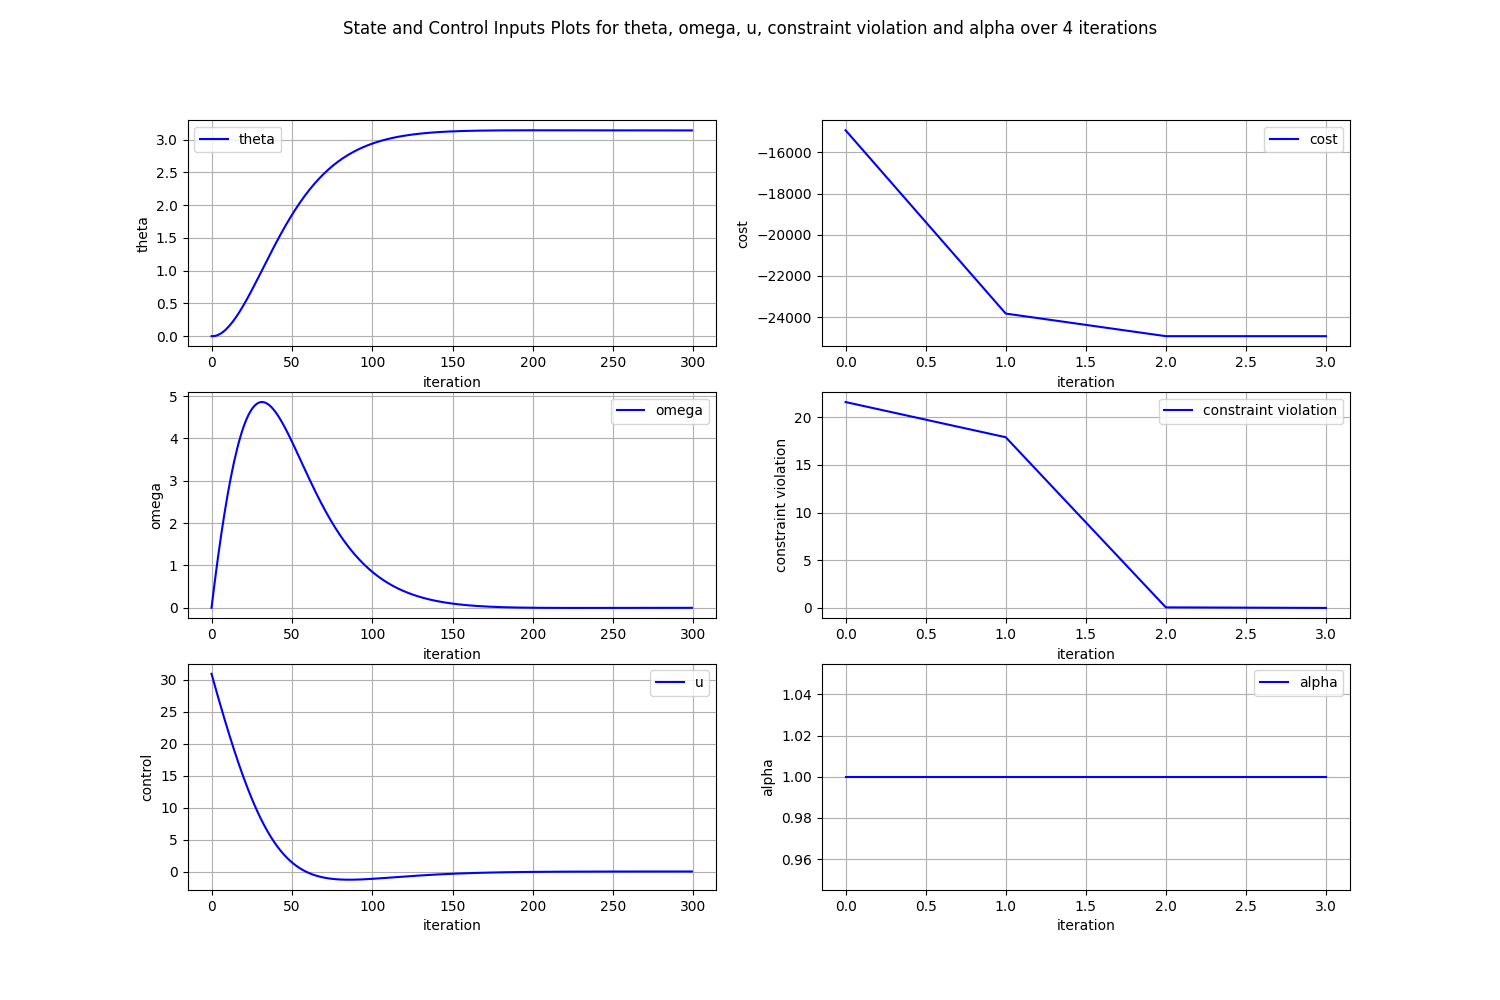

In [33]:
# Plot all variables

x_figsize = 15
y_figsize = 10
# Create a time array based on the number of columns in x1 or x2
time = np.arange(theta.shape[1])

# Create a single figure with a 3-row, 2-column layout
fig, axs = plt.subplots(3, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(
    f"State and Control Inputs Plots for theta, omega, u, constraint violation and alpha over {i+1} iterations")

# Plot theta
axs[0, 0].plot(time, theta[0, :], label='theta', color='blue')
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('theta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot omega
axs[1, 0].plot(time, omega[0, :], label='omega', color='blue')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('omega')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot u
axs[2, 0].plot(time, controls[0, :], label='u', color='blue')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('control')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot cost
axs[0, 1].plot(cost_history, label='cost', color='blue')
axs[0, 1].set_xlabel('iteration')
axs[0, 1].set_ylabel('cost')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot constraint violation
axs[1, 1].plot(c_history, label='constraint violation', color='blue')
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('constraint violation')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot alpha
axs[2, 1].plot(alpha_history, label='alpha', color='blue')
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('alpha')
axs[2, 1].legend()
axs[2, 1].grid(True)

## Question 2: write a SQP solver with inequality constraints
Modify your SQP solver in order to enforce the additional constraint $-4 \leq u_n \leq 4$. 

In this case you will need to use a QP solver instead of the ``solve`` function. Please use the [qpsolvers](https://pypi.org/project/qpsolvers/) library (use ``pip install qpsolvers`` to get the latest version 4.4.0 and use ``cvxopt`` as QP solver). You may access the Lagrange multipliers of the solution following [this example](https://qpsolvers.github.io/qpsolvers/quadratic-programming.html#dual-multipliers).

Update the convergence checks accordingly (using the KKT condition for the nonlinear problem $\nabla_x L$). Also update the computation of the constraint violation by computing the amount of inequality constraint violation in absolute value (note that it should be zero when the constraint is satisfied).

Once you have a solution, make sure to check that it satisfies the constraints! You can also use the function ``pendulum.animate_robot`` to display the pendulum motion. Please answer the following questions:
1. How many iterations did it take?
2. Plot the solution (angle, velocity and control)
3. Plot the amont of constraint violation per iteration of the solver
4. Plot the cost per iteration of the solver
5. Plot $\alpha$ for each iteration of the solver
6. Compare this solution with the solution from Question 1. Are there any qualitative differences in the pendulum behavior? Did the solver converge faster or slower?

In [34]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
from scipy.linalg import block_diag

from qpsolvers import solve_qp, Problem, solve_problem

import pendulum

# Set the max number of iterations
N2 = 500

# Modify the tolerance
tol = 1e-7

In [35]:
# dt is defined here
print(f'we use the following dt={pendulum.dt}')

# and g here
print(f'we use the following g={pendulum.g}')

# you can use this animate function to display what the pendulum would do for a given sequence of control
# N = 300
controls = np.zeros((N2, 1))
x_init = np.array([[1.0], [0.]])
pendulum.animate_robot(x_init, controls.T)

we use the following dt=0.01
we use the following g=9.81


<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAdhNtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
Dx9liIQAP//+92ifAptaQ3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAAVt6RlhkJ0L/JiAAAFfACy
BmSZ6XFJE4APMMeydN00/CqHQhhc9yCzH9V06A+2kmTfGbPbmhAPY3EgkBOOM8Ue0I9hJLKvPs/l
qmb6oagJo7SFBr1OBuUCQQFG2xsmgmMN/KGNBIqjFM17HZsrECpFM2gzb3sRbGaX3YXhKCoBr2Vv
Btnz7czyXRN90c1rKBwG6h7+y1G9RctmKdYkNfZ9PIcL6+yDtJIOH1UIAuj9/wue2ZtEw6TSqBcK
L8eOssBoMcX7PXzJUsrbPviIbDjdWE10mfuw6TofcTbVsC7GFr0ZwVPYH+AOycAUFjmAGJk95XFX
RxCqPJz61rNvSkCKxJc2DnDq23y1nGBZ0W7xxqpU/igREKd8+qFqImDJ6q/ECIqJRDeL1+W9gvs0
B80Nn771qo1L6r8JJWhIyfsnvASOIfl+rVzNt0o2qwOxtlViXrpFGFdX+hJ/+A42nrNzSIvQobCb
1WYV+0aZtiJfPn6w1PvG4sdtX+BT8hpKEx+lGo4fw7gE1OQzWCRSf/UNjadsZRLvGuvYUKCdwTEk
WfopPqa1ddCsc1nlIPX5fys0H90Iqbz/qYO8ABZaIWjQvl/bvZyxMzeSWpapBIGfgt9jxS/GqcPn
5qzL5Crt5M3tXI70PXm9Vla/HVaCxgPICI9z6B9hJKucXbnulv0Tx3pgWGkq4zCJoUSDQbMTKpHP
1+uP9z8QZom84f5DU6BeXVvtHm4djF23BlQKdhX2EUStmmG6N08XGoAVuMW72rKKVN6VdHRgsHNr
x3MR4qDMgAxERdUoQ7BXRJr4BX5soPZq/wcjolq6sTi1OvLDBtyBLPszN6tiPcUaMheYx0iV67aE
zZf/BUqm/lhAt8bzKYdsJ9/lcztqCxibPrNj5oyGn3C0REKARQj2zVOcjGQ+FMzZO2661ZGQyDFz
iir12w0bCCrErPPWnwawwtU4EcDyMcfy1O9nup++LMTj/9v5cGKwseLrqDKDLRy72SeWx0X1PS2r
gB5EoiitXz2syX3fZtL7eXGNp9LGfmQZvNn/8kQNYLyikrHwFtnL/NwLzzF1wqLYpRm7lnQcAK08
DUly7RKGunCX7cfEaLO2YI9VVl+nEQ2TqljRHoLZQNFsTQaOP2j4XG3YVytCbVbGIVASp/oAF//C
akP9qPwHBSjbB7Vl1PzegCEE2WGcj6HcMQiBVCgqScX7ZGCN7Zmpw1NB3YCxQiiE8wL1YVsNmsYO
OzTCcB1dAQrunxz+XTX/soaN28JssW843JkHpaZYMvll6F5RLvkCJmjRbb2sPWkcdKrr049Kyx0y
79yNR4wKycFmNozOSusbiujAOLdF+1YGixy4v91128C64QywR9ROS1PdihlQ5EsFxq/J9Yoc9iF3
UCuzDfjEBclfDEzkue5Ah47bQk6pa55v9JCKZmOg+HuqtJCWNdZB4hpBtGP95iFkbRtWQQTxUt4n
som/TaoCxzrc+Z4aIsma8+MyXGgaBgR5HVvzA3fpSnOia1FABYUU2rnBJdXAp9O7LU0Ypyx4czuq
WZFlPoFpwLpMmDVxo7sHgsR6rqKNbhawN/G/6zPVVLQmsHcPOM6PB9smQpgsGgDxgnQsPoilauVz
0PzsN5lNeoRnkCKNHH4APkFrP7Y1AUIkKNHJxg6lK6S3GY6WPJbeOtt3uwZe+EqMc76a15MoXOcf
cLj/qcfzADevR/eJisxU8oAjEFXCgGOHAYkhLNLWrCiRRw3eVRU9mQsjkHcx9bj7iL61v2mEENkI
JWnigX0Wid87/KfaVRy/YfdZgdi9/sl8U+AtFNd/qqSqAU9qsXfZpt9OlpnL5/9vx8kr2fVvRBUl
RYZQZZKeD0oh/lIJecwNx/ncXlEfLnOlCPzwzA6i+tlh5nEEAzGsd8RqlTXAhcMZ9fhD/cpfQ5Gl
9pj3DQJt8W0YUCJ/4o+QltdsRxCPVpc0Z3UZqOxUfnGSLoZ+G3A8qfFwhlOHAAl1NF6RVy13cn09
tT4H17QkXW9DX44NFszXEAHzGxKyE+jFMZXVmxDR2cFgdiXNiw7zfp1tcybZVsYdC4bXAehdmGBJ
IjzOUjnaYVUdL1mo6LixvKYYmr8VNead+mwz0UOSzM96Vl07rRMq1v5tCg4HSZz2zOKjA4S+BXPD
Q2wiIO87HTs4QrVOYUwEjH7/R6aZdr83y0uw8hwTd27X8R+WGoJcmIJ4d7r2GqNicXuMW//huBeH
J15j6MqA0cV9hl5qX8x41liORWI3os0bXDmtjZ6NwcCrMgVMV2E2RB7XF9EclND5J/q2Vnb6MiQG
xb8ZcsjwxS7juReW6xGPaPXb9Fmq3WJbj3g7Tih0kPgIFFeBHwoC4A7VvW7ivRXvjl/wiyT3QrEq
QQYBDxdv/R6vBF61VJGgzEcJlfp4xND1uyyRUc222gkttBj4ikMPVWvXx5iSAvhM+lkOgoaiB7cx
iCm49XPRD7CoR75XfE7+V3Sum2whtGCAo9qq9/yad3TEEkxvgTjvOh1RlNV29BeuY3OhmNHIyn25
hKYnwkK7zRnCGsiP4ii3Brm0iaKVTe+10WS6tFXBh6TAP6kDyGSoru3pNORoTfOiGv3UJfWnDIOy
x/gziqkHG7MvBV8+k3Dj20jf87ozfu1X5O1JlCCQ830nOQ2nFIoHPLkKwQEe7d0aSTFD5H/SIkH+
4ud6nhLSXdEonCTJ1WxkiFbkPJW2BcBOgSyfZDUxoTjL9Wx7RKkCQyH6hFcALN6HmhMrhVJ+6cAU
T7BvRtFl+NTOWWOC5+erQcx0wVmBDS/meofCCY81Z6QYONpUUkv9WkGrKY2H5+HbSZ14aL3NF7fE
EV+8S83Vh3d9Ztb/uwOz9

## Solution 2

### Algorithm - Additions and Changes

#### 9. Handling Inequality Constraints

An additional constraint of $$-4 \leq u_n \leq 4$$ has been given to us. 
Firstly, let us reformulate them to look like $H(\bar{x}) \bar{x} \leq h(\bar{x})$
$$\begin{bmatrix}0 & 0 & 1 \\ 0 & 0 & -1\end{bmatrix} \begin{bmatrix}\bar{\theta}_n \\ \bar{\omega}_n \\ \bar{u}_n\end{bmatrix} \leq \begin{bmatrix}4 \\ 4\end{bmatrix}$$

We shall apply the same logic as before to linearlise this equation $w.r.t.$ $\Delta x$ to get $H(\bar{x}) \Delta x \leq h(\bar{x})$,
$$\begin{bmatrix}0 & 0 & 1 \\ 0 & 0 & -1\end{bmatrix} \begin{bmatrix}\Delta \bar{\theta}_n \\ \Delta  \bar{\omega}_n \\ \Delta  \bar{u}_n\end{bmatrix} \leq \begin{bmatrix}4 - \bar{u}_n \\ 4 + \bar{u}_n\end{bmatrix}$$

Using this logic, the below function has been defined.

In [36]:
def form_ineq_const(bar_x: np.ndarray, N=500):
    """
    Constructs the inequality constraint matrices for control input bounds in the optimization problem.

    The constraints are defined as:
        -4 <= u_n <= 4 for each control input u_n across all N time steps.

    These are reformulated to the standard inequality form:
        H * Δx <= h

    Args:
        bar_x (np.ndarray): Current solution vector of shape (3*N, 1), containing variables [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N-1}, omega_{N-1}, u_{N-1}].
        N (int, optional): Number of time steps. Defaults to 500.

    Returns:
        tuple:
            - H (ndarray): Inequality constraint matrix of shape (2*N, 3*N).
            - h (ndarray): Inequality constraint bounds vector of shape (2*N,).
    """
    # Define the inequality constraint coefficients for a single time step.
    # Each control input u_n has two constraints:
    #   1. u_n <= 4  --> [0, 0, 1] * [theta_n, omega_n, u_n] <= 4
    #   2. -u_n <= 4 --> [0, 0, -1] * [theta_n, omega_n, u_n] <= 4
    H_i = np.array([
        [0, 0, 1],   # Coefficients for u_n <= 4
        [0, 0, -1]   # Coefficients for -u_n <= 4  (equivalent to u_n >= -4)
    ], dtype=np.float64)

    # Construct the block diagonal matrix H by repeating H_i for each of the N time steps.
    # This results in a (2*N) x (3*N) matrix where each pair of rows corresponds to the constraints for a specific u_n.
    H = block_diag(*([H_i] * N))

    # Extract the current control input values u_n from the solution vector bar_x.
    # Assuming the variables are ordered as [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N-1}, omega_{N-1}, u_{N-1}],
    # the control inputs are located at indices 2, 5, 8, ..., which corresponds to slicing with a step of 3 starting from index 2.
    # Extract current u_n values as a 1D array of length N
    # Extract current u_n value
    u_k = bar_x[2::3].flatten()

    # Initialize the h vector to store the upper bounds for each inequali
    # Create an empty array of length 2*N to hold all h valuesty constraint.
    # There are two constr
    # Create an empty array of length 2*N to hold all h values
    h = np.empty((2 * N,))

    # Populate the h vector with the appropriate bounds for each control input.
    for n in range(N):
        # Constraint 1: u_n <= 4
        # Reformulated as [0, 0, 1] * [theta_n, omega_n, u_n] <= 4
        h[2 * n] = 4 - u_k[n]    # Ensures that u_n does not exceed 4

        # Constraint 2: -u_n <= 4  (equivalent to u_n >= -4)
        # Reformulated as [0, 0, -1] * [theta_n, omega_n, u_n] <= 4
        h[2 * n + 1] = 4 + u_k[n]  # Ensures that u_n does not go below -4
    # Return the constructed inequality constraint matrix H and bounds vector h
    return H, h

#### 10. Reformulating KKT Solver to include inequality constraints

Now that we have a set of inequality constraints as well, our KKT needs to be reforumalted as below, 
$$\begin{equation}
\begin{aligned}
    \min_{p} \quad &p^T \nabla_{xx}^2 \mathcal{L}(x_k) p + p^T \nabla f(x_k) \\
    \text{subject to} \quad & \nabla g(x_k)^T p + g(x_k) = 0 \\
    & \nabla h(x_k)^T p + h(x_k) \leq 0
\end{aligned}
\end{equation}$$ 

Which is the same as solving

$$\begin{equation}\notag 
    \begin{bmatrix} 
        \nabla^2_{xx} \mathcal{L}(x_k) & \nabla g(x_k) ^T  & \nabla h(x_k)^T \\
        \nabla g(x_k) & 0 & 0 \\
        \nabla h(x_k) & 0 & 0
    \end{bmatrix}
    \begin{pmatrix} 
        p_k \\ 
        \lambda_{k+1} \\
        \mu_{k+1} 
    \end{pmatrix} 
    = 
    \begin{pmatrix} 
        -\nabla f(x_k) \\ 
        -g(x_k) \\
        - h(x_k)
    \end{pmatrix}
\end{equation}$$

Where $\nabla g(x_k) $ is the Jacobian of the equality constraints and $\nabla h(x_k)$ is the Jacobian of the inequality constraints. Please note that the signs on the right-hand side of the equation sometimes need to be modified, depending on how these matrices have been computed. Upon testing, in our case, the signs have been decided and the logic implemented in the form of a function as shown below. 


In [37]:
def solve_KKT_eq_ineq_constr(bar_x: np.ndarray):
    """
    Solves the Karush-Kuhn-Tucker (KKT) conditions for the current guess of the optimization variables,
    incorporating both equality and inequality constraints.

    This function formulates and solves a Quadratic Programming (QP) problem that represents the
    KKT conditions for the Sequential Quadratic Programming (SQP) optimization algorithm. It
    takes the current solution guess `bar_x`, constructs the necessary matrices and vectors for
    the QP, and utilizes the 'cvxopt' solver to find the optimal step direction and updated dual variables.

    Args:
        bar_x (np.ndarray): 
            The current solution vector of shape (3*N2, 1), where N2 is the number of time steps.
            The vector is structured as [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N2-1}, omega_{N2-1}, u_{N2-1}].
            - theta_n: Angle at time step n.
            - omega_n: Angular velocity at time step n.
            - u_n: Control input at time step n.

    Returns:
        solution (Solution or None): 
            The result object returned by the QP solver (`cvxopt`). If the solver successfully finds a solution,
            it contains the optimal step direction and dual variables. If the solver fails, it returns `None`.
            It is the responsibility of the caller to handle the case when `None` is returned.

    Raises:
        ValueError: 
            If the QP solver fails to find a solution, a `ValueError` is raised with an appropriate message.

    Example:
        >>> current_guess = np.zeros((900, 1))  # Example for N2=300
        >>> solution = solve_KKT_eq_ineq_constr(current_guess)
        >>> if solution is not None:
        >>>     step_direction = solution.x.reshape(900, 1)
        >>> else:
        >>>     print("QP solver failed to find a solution.")
    """
    # Compute the Hessian matrix of the Lagrangian with respect to the optimization variables
    # The Hessian captures the second-order partial derivatives of the Lagrangian function,
    # which is essential for defining the curvature in the QP subproblem.
    lag_hess_mat = compute_hessian_L(N=N2)

    # Compute the Jacobian matrix of the constraints and the residuals
    # G_eq represents the Jacobian of the equality constraints evaluated at the current guess `bar_x`.
    # g_eq represents the residuals of the equality constraints, indicating how much the current guess
    # violates these constraints.
    const_jac_mat, const_mat = compute_G_g(bar_x=bar_x, N=N2)

    # Compute the gradient of the cost function at the current guess `bar_x`.
    # This gradient is used in the linear term of the QP's objective function.
    cost_grad_mat = cost_grad(bar_x, N=N2)

    # Formulate the inequality constraints for the QP.
    # `form_ineq_const(bar_x=bar_x)` returns a tuple where:
    # - The first element is the inequality constraint matrix G (shape: [2*N2, 3*N2]).
    # - The second element is the inequality constraint bounds vector h (shape: [2*N2,]).
    G_ineq, h_ineq = form_ineq_const(bar_x=bar_x)

    # Create the Quadratic Programming (QP) problem instance using the `Problem` class from `qpsolvers`.
    # The QP is defined as:
    #   minimize (1/2) * p.T * P * p + q.T * p
    #   subject to A * p = b
    #              G * p <= h
    problem = Problem(
        # Hessian matrix of the Lagrangian (shape: [3*N2, 3*N2])
        P=lag_hess_mat,
        # Gradient vector of the cost function (shape: [3*N2,])
        q=cost_grad_mat,
        # Jacobian matrix of equality constraints (shape: [num_eq_constraints, 3*N2])
        A=const_jac_mat,
        # Residuals for equality constraints (shape: [num_eq_constraints,])
        b=-const_mat.flatten(),
        # Inequality constraint matrix (shape: [2*N2, 3*N2])
        G=G_ineq,
        # Inequality constraint bounds vector (shape: [2*N2,])
        h=h_ineq.flatten()
    )

    # Solve the QP problem using the 'cvxopt' solver.
    # The solver attempts to find the optimal step direction `pk` that minimizes the QP's objective
    # while satisfying both equality and inequality constraints.
    solution = solve_problem(
        problem=problem,
        solver="cvxopt",
        verbose=False,    # Suppress solver output for cleaner logs
        initvals=None     # No initial values are provided; the solver uses default initialization
    )

    # Check if the solver successfully found a solution.
    if solution is None:
        # If the solver fails (e.g., due to infeasibility or numerical issues), raise an error.
        raise ValueError("QP solver failed to find a solution")

    # Return the solution object containing the optimal step direction and dual variables.
    return solution

#### 11. Reformulating total constraints violation 

Earlier, we were checking only for the violation in equality constraints. Now we must also include the computation for inequality constraints as well. 
To do so, all we do is comput how much the control is violating one of the bounds and sum all the violations up. This logic is implemented below.

In [38]:
def tot_constraint_violation_eq_ineq(bar_x: np.ndarray, verbose=False):
    """
    Calculates the total constraint violation for both equality and inequality constraints
    based on the current solution vector `bar_x`.

    This function computes the sum of absolute violations for equality constraints and 
    control input bounds (-4 <= u_n <= 4). It provides an option to print detailed 
    constraint violation information.

    Args:
        bar_x (np.ndarray):
            The current solution vector of shape (3*N2, 1), where N2 is the number of time steps.
            The vector is structured as [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N2-1}, omega_{N2-1}, u_{N2-1}].
            - theta_n: Angle at time step n.
            - omega_n: Angular velocity at time step n.
            - u_n: Control input at time step n.
        verbose (bool, optional):
            If set to True, the function will print detailed information about constraint violations.
            Defaults to False.

    Returns:
        float:
            The total constraint violation, which is the sum of absolute violations from both
            equality and inequality constraints.

    Example:
        >>> bar_x = np.array([theta_0, omega_0, u_0, ..., theta_N2-1, omega_N2-1, u_N2-1]).reshape(3*N2, 1)
        >>> total_violation = tot_constraint_violation_eq_ineq(bar_x, verbose=True)
        >>> print(total_violation)
    """
    # Compute the total violation for equality constraints
    # `compute_G_g(bar_x, N=N2)` returns a tuple where the second element is the residuals of equality constraints
    # Taking the absolute value of each residual and summing them gives the total equality constraint violation
    constraint_violation_eq = np.sum(abs(compute_G_g(bar_x, N=N2)[1]))

    # Extract the control input values (u_n) from the solution vector `bar_x`
    # Assuming the variables are ordered as [theta_0, omega_0, u_0, theta_1, omega_1, u_1, ..., theta_{N2-1}, omega_{N2-1}, u_{N2-1}]
    # Control inputs are at indices 2, 5, 8, ..., hence `2::3`
    u = bar_x[2::3].flatten()

    # Initialize the total inequality constraint violation
    constraint_violation_ineq = 0

    # Iterate over each control input to calculate inequality violations
    for u_i in u:
        if u_i > 4:
            # If the control input exceeds the upper bound, accumulate the violation amount
            constraint_violation_ineq += np.abs(u_i - 4)
        elif u_i < -4:
            # If the control input is below the lower bound, accumulate the violation amount
            constraint_violation_ineq += np.abs(-u_i - 4)

    # Alternative method to calculate inequality constraint violations (commented out)
    # This line sums the absolute values of the inequality residuals directly
    # constraint_violation_ineq = np.sum(abs(form_ineq_const(bar_x=bar_x)[1]))

    # If verbose mode is enabled, print detailed information about constraint violations
    if verbose:
        print(
            f"Equality Constraint Violation = {constraint_violation_eq}    Inequality Constraint Violation = {constraint_violation_ineq}")

    # Return the sum of equality and inequality constraint violations as the total violation
    return constraint_violation_eq + constraint_violation_ineq

#### 12. Filter Line search

Now that we have a value of $\bar{x}$, the next thing to do is perform line search to compute $\alpha$. We shall use the total constraint violation function for this purpose. 

In [39]:
# Initialize the decision variable vector with zeros
# The vector `x_guess` contains all the optimization variables for the problem
# Assuming each time step has 3 variables: theta (angle), omega (angular velocity), and u (control input)
# Therefore, for N2 time steps, the total number of variables is 3*N2
x_guess = np.zeros((3 * N2, 1))  # Shape: (3*N2, 1)

# Initialize the Lagrange multiplier vector (dual variables) with zeros
# This line is commented out, possibly for future use or alternative implementations
# lambda_guess = np.zeros(((2 + (2 * N)), 1))

# Initialize the step size `alpha` for the line search algorithm
alpha = 1  # Starting with a full step size

# Set the reduction factor `rho` for backtracking line search
rho = 0.5  # Each time the step size is reduced by multiplying with rho

# Initialize the best (minimum) constraint violation encountered so far to infinity
c_best = np.inf  # Represents the lowest constraint violation achieved

# Initialize the best (minimum) cost encountered so far to infinity
cost_best = np.inf  # Represents the lowest cost achieved

# Initialize lists to keep track of the history of costs, step sizes, and constraint violations
cost_history = []      # Stores the cost at each iteration
alpha_history = []     # Stores the step size alpha at each iteration
c_history = []         # Stores the constraint violation at each iteration

# Begin the main optimization loop, iterating up to N2 times
for i in range(0, N2):
    # Solve the Karush-Kuhn-Tucker (KKT) conditions to obtain the search direction `pk`
    # The function `solve_KKT_eq_ineq_constr` returns an object with the optimal solution `res.x`
    res = solve_KKT_eq_ineq_constr(x_guess)

    # Reshape the solution vector `res.x` to match the shape of `x_guess`
    # `pk` represents the search direction for updating `x_guess`
    pk = res.x.reshape(N2 * 3, 1)  # Shape: (3*N2, 1)

    # Perform backtracking line search to find an appropriate step size `alpha`
    # The loop continues reducing `alpha` until both the cost decreases and constraint violations are reduced
    while ((cost_func(bar_x=(x_guess + (alpha * pk)), N=N2) >= cost_best) &
           (tot_constraint_violation_eq_ineq(bar_x=(x_guess + (alpha * pk))) >= c_best)):
        alpha = rho * alpha  # Reduce the step size by the factor `rho`

    # Update the best constraint violation with the new candidate solution
    c_best = tot_constraint_violation_eq_ineq(
        (x_guess + (alpha * pk)), verbose=False)  # Calculates total constraint violation

    # Update the best cost with the new candidate solution
    cost_best = cost_func((x_guess + (alpha * pk)),
                          N=N2)  # Calculates the cost

    # Append the current step size, constraint violation, and cost to their respective history lists
    alpha_history.append(alpha)          # Record the step size
    c_history.append(c_best)             # Record the constraint violation
    cost_history.append(cost_best)       # Record the cost

    # Print the current status of the optimization
    print(
        f"Current Cost = {cost_best}  Current Constraint Violation = {c_best}   alpha = {alpha}")

    # Update the decision variable vector `x_guess` by taking a step in the direction of `pk`
    x_guess = x_guess + (alpha * pk)  # Shape: (3*N2, 1)

    # Extract the theta (angle) values from the updated `x_guess` vector
    # Assumes theta values are at indices 0, 3, 6, ..., i.e., every 3rd element starting from 0
    theta = x_guess[0::3].T  # Shape: (1, N2)

    # Extract the omega (angular velocity) values from the updated `x_guess` vector
    # Assumes omega values are at indices 1, 4, 7, ..., i.e., every 3rd element starting from 1
    omega = x_guess[1::3].T  # Shape: (1, N2)

    # Extract the control input `u` values from the updated `x_guess` vector
    # Assumes u values are at indices 2, 5, 8, ..., i.e., every 3rd element starting from 2
    controls = x_guess[2::3].T  # Shape: (1, N2)

    # Check if the current constraint violation is below the specified tolerance
    if (c_best < tol):
        break  # Terminate the loop early if convergence is achieved

# After completing the iterations, print the total number of iterations performed
print(f"Total iterations needed = {i+1}")

# Extract the final optimized variables for further analysis or visualization
# These lines appear redundant as they are already inside the loop, but are retained as per the original code
theta = x_guess[0::3].T      # Shape: (1, N2)
omega = x_guess[1::3].T      # Shape: (1, N2)
controls = x_guess[2::3].T    # Shape: (1, N2)

Current Cost = -10816.493184907964  Current Constraint Violation = 0.9908629060371589   alpha = 1
Current Cost = -11042.385670136158  Current Constraint Violation = 0.024708514552588025   alpha = 1
Current Cost = -11059.561257270565  Current Constraint Violation = 0.014084372022174527   alpha = 1
Current Cost = -11073.087698384928  Current Constraint Violation = 0.011811533360092124   alpha = 1
Current Cost = -11085.03085885569  Current Constraint Violation = 0.010912803839330631   alpha = 1
Current Cost = -11096.452191146273  Current Constraint Violation = 0.010952019662052823   alpha = 1
Current Cost = -11108.232914823873  Current Constraint Violation = 0.01190542615073434   alpha = 1
Current Cost = -11121.35469029571  Current Constraint Violation = 0.014037157900781055   alpha = 1
Current Cost = -11137.17692803198  Current Constraint Violation = 0.017982295928385638   alpha = 1
Current Cost = -11157.905634840909  Current Constraint Violation = 0.025121394022481914   alpha = 1
Curren

In [40]:
# Animate the pendulum
x_init = np.array([theta[:, 0], omega[:, 0]])
pendulum.animate_robot(x_init, controls)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXWVtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE4
IGxvb2thaGVhZF90aHJlYWRzPTMgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
DQdliIQAEP/+94G/MstfIrrJcfnnfSyszzzkPHJdia640AAAAwAAAwABR4e1643dg1tJ0AAAGsAD
pCLH/2+kONwAT9lg/NYjL/FoB9aiK4jE+YrYPvM3VJY4vjNnyLGP2YlbJp/NpA8k+C6YwpDlXn2f
y1TN9QNLS2doYg16nA3KBIICjrY2PQjGG/lJWgkVRima9js6Vx5WimbQrt72ItjNL7sLxElEA17m
hCeWbA7zyXROB8c1qwBwG6mF4Z9p4RctmYdY75fZ9PIcL6+1DtNo159DsIedHWW5BeeoUeMIr15+
LI/6q7q3wu/lDZN9tIlTOzRJ5hxurCa6TP3YdJ0Pua9/TkOnB1BZtIQdZE2NNeG6ZBWKX2qe8rir
o4hVHk6AK1m3pSBFYkubBzjVbb5azjAs67d441UqfxQIdZAC3wXGhd0Df4sjAsAiUQ3i9flvYL7N
AfNDl++9aqNS+m/EntCRwqCe8BI4h+X6tXM0ZlI2ui7fnCbPrzprCur/Qlv/AcWwh2PCPV27J9Hh
B4sbRpm2Il9JEsGqAKrFjtq/wKfkNJeUUJRqCO8O4BNTkM1gkUt/4YYDveK6vKxrr1xGInxBFkRx
Ra/U1q66FY5rPKRGvy/lhCV0gLPWM/Uwd4ACy0QsnRfL+3ezliZm8228ZiCQM/Bb7Hih+NU4fPzV
mXyFXbybWT3q7qlyOdubg07ODGm3wBRMgDV2F09QRWcgoRac1e6IX088F59nygAudtZ5wAAASwwU
cqaZXL0UXzviZELNw197oAtAbVd689mZlrxJVD2nKaUzy2QETgxH+VjLUGW4nahqUgWQqDMfnRA9
lcxOpvul0EAwcmU/0ADaLvjFil9t7FUYKNxT6HPKJl9bOWLYqE+Cy39/mB8mN+2C9yTgeLkAYVNj
W62F82r/AqVC2BbuZp4VB+J9deuuOciIUAihH1mqc5GMh8KZmyduCGi7jBcE8GKK7Ktho1WaT7h0
oHuZDvhA+oN7r4xx/LU72e6n74sxOP/4YHwYrCx4uunVofIvqDyI8tU9VfBCymj6+aeibavntZjy
E6vpfbntb9PpYz8yDN5s//onJnSdeCwDlC2zfnnDF5/i64VFsUozdyzoOAFZ/mOlz4pgdYHuape7
FIxIdRoSAawZDZO38KdLp+RpovTr0L2f0BYxITknCj6MVWNAzL4MZObkl/IMFvB8GmNlRoJiqJlg
j7pjd+Pg+TIcTaOh3Hhwm1LCfZq7F2gKNLavE+1/fnaJu2EkPlDbBe79z2sK2GzWNH8dQ2kX9Oge
pUTFn7s8Xu+B5dZO3dtidtkByvTKE4cqyaIZ+rn6dU/TojPRCHEEcSW3uTbLaaRKYavFukjysCpZ
scunqr5KYxW3tLQpyuc2aArtrn1H00FYc1TZvL03yIlB6lsdzhvwJguMxE2xPkvhZ0bNHqud8P+9
yV7E9n6ZCECHjttCTTUuzCf2MDguo0pWFP5+n4WXO09zTmZyubzXPaEplpn4jT/t+viDgeZsozn5
9wJlq8rKAHxTBVD3odq1mhYfEY4xEa2NMwDnvFHDUBIzgdDU8eitxaXj6uwhVExHadYR54HV5/tJ
+YmZjURkeHMZudpH61oo1uFrAo2P/1meqqWhNYO1yD7m9JwwGU4qnbvcZ/tpzDypiPFPy7fnYbzK
IOhnl4q5JN4yDVlbQHqjBeBO7R4aZQvhMQKdbA8GDQokC8xJSFS3c4ToRTRzv/B78Br1lIzWOmxp
JXpOjhsN0TNF4XRN0KHONI2JyeXuWmlqfAbXNuSTNTujaWOvaw0EG76Eu/8KrrYs94bGcD3UtCFI
xUH7M11OFU4u8f/PluX83tm3xJGFrF39amDe7ckATbH89J8Gge+x5HeiTYn64GZuLuv5uOXg6g73
yuKmjdxCMcFOBoHWw/45aXgYGinn16ign3t5ivkwTycaQff5fXK0tILpp6Nz1p34YkfB07JLOZBA
N+F8nDZ+H3/wH9EloxF3sH+11dSayXh39s9iToKufm96QZ4QJ8+YYPkuORZD6r3i9VE6dboP/Zxz
Yky/J23uigsDsSouvJsQu1owKu0sLpt/3aiMmXOT9l2VdjHsona9ITCAXNaINUVF4X/cb7DVIa+7
1lhOMv1bHtEidAIu0gLsp4N9SlMS/ennvPL61Tp3UJbYfQjx46hUVEsmgfbcGIdMBpgN7/8HXIbj
+0MVu83Dq1heJGDsTRtWcFPtTE7yD6P6EW9DiYoYWIsez5Q0lOYevz6Ktmb8krt3AD89bDijWM2G
prImxPLabhH8JrnaaSs1xjv5TFFHvWfKGqwWbej3QUaHYPPaI/vjuRJAbix6WxxO+1wvof30Zt5F
RL+8hH0xv2AugYYB4oQJEAA7DH8cLDDbBxDu8RhBKOFr4l8HR1N2Q4ieXbeYunPkQwmAXKgXknzv
MmvIJZvAmp7HZ7caOuQkVMT9LNx/E5gIoKCAcQV1mQx+M5Txf7KSdyh3zjcR/3kg3d253TL5npBy
f6FZFzl3+/GcgwLm55VXiuMhCOkMgFeFmbgaBEHpOF2aY8Nxsj64avsvzQxE0/HK1YKHW/KR2uXe
RVuRvquqSyzNawqkXOYIA4inXVdAtfqjVbHzBdfTtiiRYoyWsuJnYCeJ3hNLsYQru080Grushgmb
7VFab2dJxa0F9bAGSpAoQE/qH8YjdaijM5VnPJG+P4tDJ5T4PEr8eRZyzDPEiFGm/V0gFjFs+xOF
DntebdeXrvPzPxRIXbUns+v/7ztLzvVbaobUFtfxpkR7qigufM4tjXEYCrNtPU5DNYJMP/4rIDlI
rskynohWkO8PUF+A3xkMLgRCyr0VdyPPZSsfKDbMwM9BfPeM/wBH25FKWz88g3+Yu5iaoE+aZBI6
u+ileC9VVhpw4SkKgHnMK

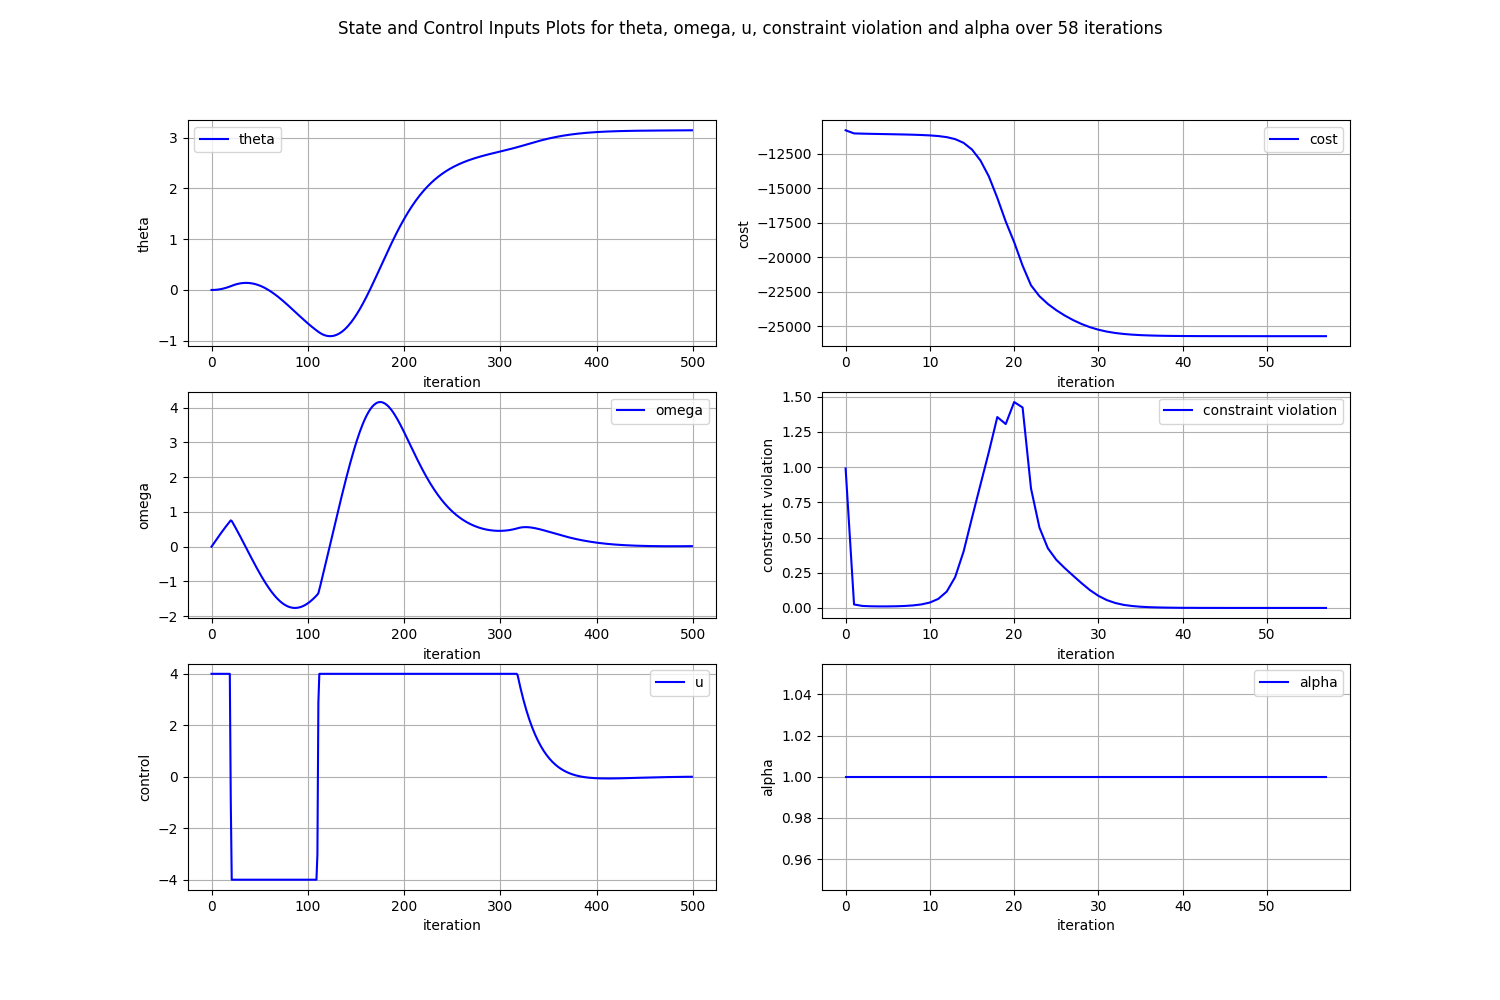

In [41]:
# Plot the variables
x_figsize = 15
y_figsize = 10
# Create a time array based on the number of columns in x1 or x2
time = np.arange(theta.shape[1])

# Create a single figure with a 3-row, 2-column layout
fig, axs = plt.subplots(3, 2, figsize=(x_figsize, y_figsize))
fig.suptitle(
    f"State and Control Inputs Plots for theta, omega, u, constraint violation and alpha over {i+1} iterations")

# Plot theta
axs[0, 0].plot(time, theta[0, :], label='theta', color='blue')
axs[0, 0].set_xlabel('iteration')
axs[0, 0].set_ylabel('theta')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot omega
axs[1, 0].plot(time, omega[0, :], label='omega', color='blue')
axs[1, 0].set_xlabel('iteration')
axs[1, 0].set_ylabel('omega')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot u
axs[2, 0].plot(time, controls[0, :], label='u', color='blue')
axs[2, 0].set_xlabel('iteration')
axs[2, 0].set_ylabel('control')
axs[2, 0].legend()
axs[2, 0].grid(True)

# Plot cost
axs[0, 1].plot(cost_history, label='cost', color='blue')
axs[0, 1].set_xlabel('iteration')
axs[0, 1].set_ylabel('cost')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot constraint violation
axs[1, 1].plot(c_history, label='constraint violation', color='blue')
axs[1, 1].set_xlabel('iteration')
axs[1, 1].set_ylabel('constraint violation')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Plot alpha
axs[2, 1].plot(alpha_history, label='alpha', color='blue')
axs[2, 1].set_xlabel('iteration')
axs[2, 1].set_ylabel('alpha')
axs[2, 1].legend()
axs[2, 1].grid(True)